In [ ]:
"""
Volatility Trees

This module attempts to predict the 30-day forward volatility of a given security
with tree-based machine learning models (Random Forest and XGBoost). In this example,
the model is run on the SPY (S&P 500 ETF).

Author: Rae Chipera - Jaxorik AI Research Group FOR Guidon Investment Club
"""

# **Volatility Prediction Model - Key Methods**
**Data Preparation:**

1. Download historical price data for SPY (or any ticker)
2. Add VIX data as an external indicator of market volatility
3. Calculate daily returns from closing prices
Compute realized volatility using a 21-day rolling window of returns
4. Create a target variable: In this case, we are predicting the volatility 30 days into the future

**Feature Engineering:**

1. Create lagged volatility features (1, 5, 10, 21, and 63 days back)
2. Calculate "volatility of volatility" - how much the volatility itself fluctuates as follows:

Find the realized volatility over a rolling window of returns:

$RV_t=σ(Returns_{t-20:t}) × √252$, where:
  *  $RV_t$ is the realized volatility at time t, *  $σ()$ is the standard deviation function,
  *  $Returns_{t-20:t}$ represents the returns from t-20 to t (21-day window), and
  *  $√252$ is the annualization factor.

Then, Vol of Vol (VoV) is calculated as the standard deviation of this realized volatility series over a rolling window: $VoV_t = σ(RV_{t-20:t})$, where
  *  $VoV_t$ is the volatility of volatility at time t
  *  $σ()$ is again the standard deviation function
  *  $RV_{t-20:t}$ represents the realized volatility values from t-20 to t

3. Include short and medium-term returns (5-day and 21-day)
4. Measure how price compares to moving averages (50-day and 200-day)
5. Add VIX-related features like VIX/realized volatility ratio and VIX momentum

**Model Training:**

1. Split data into training (80%) and testing (20%) sets, preserving time order
2. Train a Random Forest model with 200 trees and max depth of 10
3. Evaluate performance using metrics like RMSE and R-squared

**Prediction and Application:**

1. Use the model to predict volatility 30 days forward
2. Compare predicted volatility to current volatility to identify trends
3. Feed predictions into Black-Scholes model to estimate future option prices
4. Generate trading strategies based on expected volatility changes

**Trading Recommendations:**

1. If volatility is expected to increase significantly: Consider long straddles or strangles
2. If volatility is expected to decrease: Look at selling premium via iron condors or credit spreads
3. If volatility is expected to remain stable: Consider neutral strategies like covered calls

This approach combines statistical modeling with options theory to create actionable trading signals based on forward volatility predictions.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Analyzing SPY volatility
Creating features...
Adding VIX data...
Using 2 features: ['vix_ratio', 'vix_change_5d']
Training Random Forest model...
Model performance:
  MSE: 0.0069
  RMSE: 0.0830
  MAE: 0.0630
  R2: -5.1147

Feature importance:
  vix_ratio: 0.5065
  vix_change_5d: 0.4935


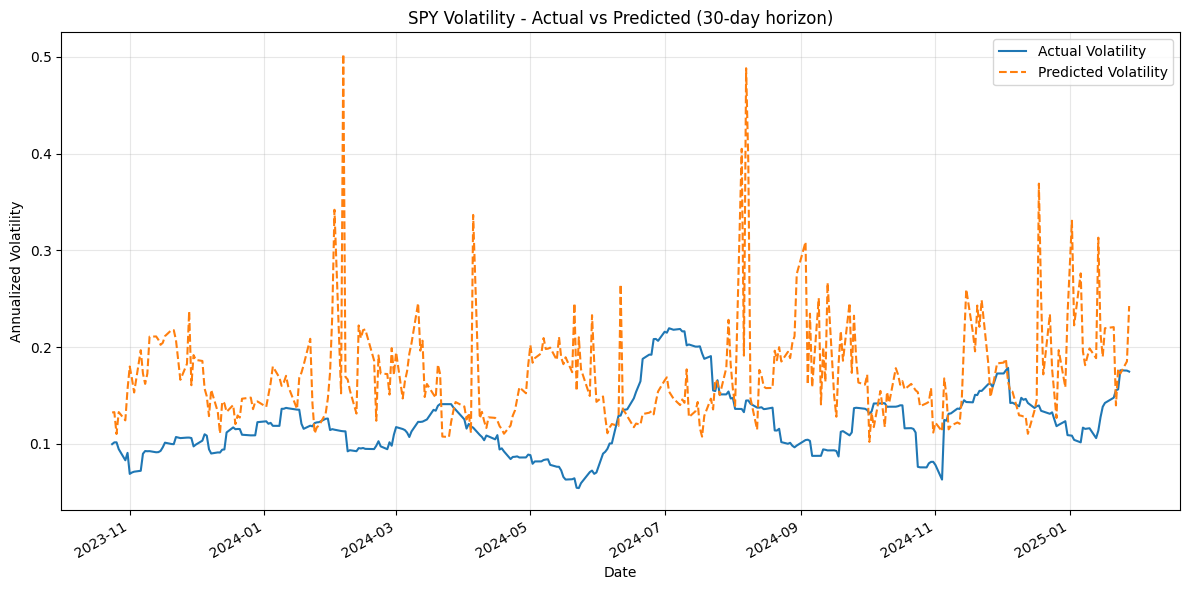


Prediction for 30-day forward volatility: 24.24%
Current realized volatility: 14.54%
Expected change: +66.69%

Options Trading Implications (Strike=$Ticker
SPY    605.0
Name: 2025-01-28 00:00:00, dtype: float64, Expiry: 2025-04-12):
Error calculating option prices: unsupported format string passed to Series.__format__


In [12]:
# Tree-Based Volatility Prediction Model
# Author: Rae Chipera / Jaxorik AI Research Group
# Created for: Guidon Investment Club

import sys
sys.path.append('/content/drive/MyDrive')  # Add trading_tools to path

# Import your existing modules
from trading_tools.watchlists import Volatility, FearGreedIndex
from trading_tools.options import BlackScholes, Greeks

# Other necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Install required packages if needed
!pip install -q scikit-learn xgboost matplotlib seaborn

def simple_vol_predictor(ticker='SPY', start_date='2018-01-01'):
    """Ultra-simple volatility predictor to avoid column issues"""

    print(f"Analyzing {ticker} volatility")

    # Get ticker data directly from yfinance
    print(f"Downloading {ticker} data...")
    history = yf.download(ticker, start=start_date, progress=False)

    # Create our features directly on the dataframe without modifying the index
    print("Creating features...")
    df = history.copy()
    df['returns'] = df['Close'].pct_change()
    df['realized_vol'] = df['returns'].rolling(window=21).std() * np.sqrt(252)
    df['target_vol'] = df['realized_vol'].shift(-30)  # 30-day forward volatility

    # Create basic features
    for lag in [1, 5, 10, 21, 63]:
        df[f'vol_lag_{lag}d'] = df['realized_vol'].shift(lag)

    # Volatility of volatility
    df['vol_of_vol'] = df['realized_vol'].rolling(window=21).std()

    # Return features
    df['return_5d'] = df['Close'].pct_change(5)
    df['return_21d'] = df['Close'].pct_change(21)

    # Price relative to moving averages
    df['price_rel_ma50'] = df['Close'] / df['Close'].rolling(window=50).mean() - 1
    df['price_rel_ma200'] = df['Close'] / df['Close'].rolling(window=200).mean() - 1

    # Add VIX data if relevant
    if ticker in ['SPY', '^SPX', 'SPX']:
        print("Adding VIX data...")
        vix = yf.download('^VIX', start=start_date, progress=False)

        # Add VIX directly using the index (dates) instead of merging
        df['vix'] = vix['Close']

        # Handle any NaN values that might result from misaligned dates
        df['vix'] = df['vix'].fillna(method='ffill')

        # Add VIX-related features
        df['vix_ratio'] = df['vix'] / df['realized_vol']
        df['vix_change_5d'] = df['vix'].pct_change(5)

    # Drop rows with NaN
    df = df.dropna()

    # Identify feature columns - use only the ones we've explicitly created
    feature_cols = [col for col in df.columns if col in [
        'vol_lag_1d', 'vol_lag_5d', 'vol_lag_10d', 'vol_lag_21d', 'vol_lag_63d',
        'vol_of_vol', 'return_5d', 'return_21d', 'price_rel_ma50', 'price_rel_ma200'
    ]]

    if 'vix_ratio' in df.columns:
        feature_cols.append('vix_ratio')

    if 'vix_change_5d' in df.columns:
        feature_cols.append('vix_change_5d')

    print(f"Using {len(feature_cols)} features:", feature_cols)

    # Prepare data for modeling
    X = df[feature_cols]
    y = df['target_vol']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train Random Forest model
    print("Training Random Forest model...")
    rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict and evaluate
    rf_pred = rf_model.predict(X_test)

    metrics = {
        'MSE': mean_squared_error(y_test, rf_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),
        'MAE': mean_absolute_error(y_test, rf_pred),
        'R2': r2_score(y_test, rf_pred)
    }

    print("Model performance:")
    for m, v in metrics.items():
        print(f"  {m}: {v:.4f}")

    # Feature importance
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nFeature importance:")
    for idx, row in importance.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")

    # Plot results
    plt.figure(figsize=(12, 6))

    # Use the test index directly with the DataFrame
    test_dates = y_test.index

    plt.plot(test_dates, y_test, label='Actual Volatility')
    plt.plot(test_dates, rf_pred, label='Predicted Volatility', linestyle='--')
    plt.title(f'{ticker} Volatility - Actual vs Predicted (30-day horizon)')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()  # Angle the dates for better readability
    plt.tight_layout()
    plt.show()

    # Make prediction for the next 30 days
    latest_data = X.iloc[-1:].copy()
    future_vol = rf_model.predict(latest_data)[0]
    current_vol = df['realized_vol'].iloc[-1]

    print(f"\nPrediction for 30-day forward volatility: {future_vol:.2%}")
    print(f"Current realized volatility: {current_vol:.2%}")
    print(f"Expected change: {(future_vol-current_vol)/current_vol:+.2%}")

    # Show option pricing implications if it's SPY
    if ticker in ['SPY', '^SPX', 'SPX']:
        current_price = df['Close'].iloc[-1]
        atm_strike = round(current_price)
        expiry_date = (datetime.now() + timedelta(days=30)).strftime('%Y-%m-%d')
        try:
            T = BlackScholes.calculate_years_to_expiry(expiry_date)
            r = 0.05  # Assumed risk-free rate

            # Calculate option prices
            current_call = BlackScholes.call_price(current_price, atm_strike, r, current_vol, T)
            current_put = BlackScholes.put_price(current_price, atm_strike, r, current_vol, T)

            predicted_call = BlackScholes.call_price(current_price, atm_strike, r, future_vol, T)
            predicted_put = BlackScholes.put_price(current_price, atm_strike, r, future_vol, T)

            print(f"\nOptions Trading Implications (Strike=${atm_strike}, Expiry: {expiry_date}):")
            print(f"  Current Call Price: ${current_call:.2f}")
            print(f"  Predicted Call Price: ${predicted_call:.2f} ({(predicted_call-current_call)/current_call:+.2%})")
            print(f"  Current Put Price: ${current_put:.2f}")
            print(f"  Predicted Put Price: ${predicted_put:.2f} ({(predicted_put-current_put)/current_put:+.2%})")

            # Trading strategy recommendation
            if future_vol > current_vol * 1.1:  # More than 10% increase
                print("\nTrading Strategy: VOLATILITY EXPECTED TO INCREASE")
                print("  - Consider long straddle/strangle positions")
                print("  - Look for opportunities to buy VIX calls or VXX")
            elif future_vol < current_vol * 0.9:  # More than 10% decrease
                print("\nTrading Strategy: VOLATILITY EXPECTED TO DECREASE")
                print("  - Consider selling premium (iron condors, credit spreads)")
                print("  - Short VIX or VXX could be profitable")
            else:
                print("\nTrading Strategy: NEUTRAL VOLATILITY OUTLOOK")
                print("  - Consider neutral strategies like butterflies")
                print("  - Current option prices likely fair")
        except Exception as e:
            print(f"Error calculating option prices: {e}")

    return {
        'model': rf_model,
        'metrics': metrics,
        'feature_importance': importance,
        'current_volatility': current_vol,
        'predicted_volatility': future_vol
    }

# Run the ultra-simple predictor
results = simple_vol_predictor(ticker='SPY', start_date='2018-01-01')